In [1]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams 
import os.path


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
## N.B. Sim time decreased to 100 because of the multimeter (to avoid kernel crash)

# Variables
tones = [20]
angles = [0]
max_ild = 0
time_sim = 100 #us

# Cell parameters
C_m_bushy = 1 #pF
V_m_bushy = -63.8 #mV

In [3]:
# Fixed
w_head = 22 #cm
v_sound = 33000 #cm/s

ANFs2SBCs_weight = 2.0
ANFs2GBCs_weight = 1.0
GBCs2MNTBCs_weight = 16.0

SBCs2LSO_weight = 16.0
MNTBCs2LSO_weight = -2.0

SBCs2MSO_weight = 4.0
MNTBCs2MSO_weights = [0, -2.0, -4.0, -6.0, -8.0, -10.0, -12.0, -14.0, -16.0, -20.0]
n_battery = len(MNTBCs2MSO_weights)

delay_inh = 0.1

mean_rate = 0
mean_amplitude = 1000
noise_rate = 0

n_ANFs = 35000
ANFs2SBCs = 4
ANFs2GBCs = 20
SBCs2MSOs = int(ANFs2GBCs/ANFs2SBCs)
SBCs2LSOs = int(ANFs2GBCs/ANFs2SBCs)
n_SBCs = int(n_ANFs/ANFs2SBCs)
n_GBCs = int(n_ANFs/ANFs2GBCs)
n_MSOs = n_GBCs*n_battery

In [4]:
for tone in tones:
    
    results_r_MSO = np.zeros((n_battery, len(angles)))
    results_l_MSO = np.zeros((n_battery, len(angles)))

    results_r_SBC = np.zeros(len(angles))
    results_l_SBC = np.zeros(len(angles))

    results_r_GBC = np.zeros(len(angles))
    results_l_GBC = np.zeros(len(angles))

    for angle in angles:

        nest.ResetKernel()
        nest.local_num_threads = 16
        nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°

        freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2)
        channel_x = np.where(freq>=tone)[0][0]
        spectro = np.zeros((3500,time_sim))
        amplitudes = np.round(stats.norm.pdf(np.linspace(-1, 1, 21) , 0, 1.0/(math.sqrt(2*math.pi)*1)),2)

        if(channel_x<10):
            spectro[channel_x:channel_x+10+1,:] = amplitudes[10:].reshape(11,1)*np.ones((11, time_sim))
            spectro[0:channel_x+1, :] = amplitudes[10-channel_x:11].reshape(channel_x+1,1)*np.ones((channel_x+1, time_sim))
        else:
            if(channel_x>3489):
                spectro[channel_x-10:channel_x+1] = amplitudes[:11].reshape(11,1)*np.ones((11, time_sim))
                spectro[channel_x:] = amplitudes[10:10+3500-channel_x].reshape(3500-channel_x,1)*np.ones((3500-channel_x, time_sim))
            else:
                spectro[channel_x - 10 : channel_x + 10 + 1, :] = amplitudes.reshape(21,1)*np.ones((21, time_sim))

        delta_x = (w_head*np.sin(np.deg2rad(angle)))
        itd = 1000*delta_x/v_sound #ms
        ipds = 2*np.pi*itd*freq/1000
        ild = angle*max_ild/90
        
        # Populations

        r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                params={'frequency': np.repeat(freq, 10),
                            'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs

        r_ANFs = nest.Create('parrot_neuron', n_ANFs)

        r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': C_m_bushy, 'V_m': V_m_bushy})

        r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_bushy, 'V_m': V_m_bushy})

        r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_bushy, 'V_m': V_m_bushy})

        r_MSO = nest.Create('iaf_cond_alpha', n_MSOs, 
                         params = {'C_m': C_m_bushy, 'V_m': V_m_bushy})


        l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                    params={'frequency': np.repeat(freq, 10),
                        'phase': 0})

        l_ANFs = nest.Create('parrot_neuron',n_ANFs)

        l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': C_m_bushy, 'V_m': V_m_bushy})

        l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_bushy, 'V_m': V_m_bushy})

        l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': C_m_bushy, 'V_m': V_m_bushy})

        l_MSO = nest.Create('iaf_cond_alpha', n_MSOs, 
                         params = {'C_m': C_m_bushy, 'V_m': V_m_bushy})

        ANFs_noise = nest.Create('poisson_generator',1,
                         params = {'rate':noise_rate})

        s_rec_r = nest.Create('spike_recorder')
        s_rec_l = nest.Create('spike_recorder')
        
        # Connections

        nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
        nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

        nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
        nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

        nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MSO, s_rec_r, 'all_to_all')
        nest.Connect(l_MSO, s_rec_l, 'all_to_all')


        for i in range(len(spectro)-1):
            if(np.any(spectro[i][:] > 0)):
                nest.Connect(ANFs_noise, r_ANFs[10*i:10*(i+1)], 'all_to_all')
                nest.Connect(ANFs_noise, l_ANFs[10*i:10*(i+1)], 'all_to_all')

        for i in range(n_SBCs):
            nest.Connect(r_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], r_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
            nest.Connect(l_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], l_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

        for i in range(n_GBCs):
            nest.Connect(r_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], r_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
            nest.Connect(l_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], l_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

        nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight})
        nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight})

        #MSO
        for i in range(n_GBCs):
            for j in range(n_battery):
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight}) 
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight})
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight}) 

        for i in range(n_GBCs):
            for j in range(n_battery):
                nest.Connect(l_MNTBCs[i], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delay_inh})
                nest.Connect(r_MNTBCs[i], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delay_inh})


        mm = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.SetStatus(mm, {'interval': 0.01})
        nest.Connect(mm, r_MSO,'all_to_all')

        if(angle>=0): 
            mean_amplitude_r = mean_amplitude
            mean_amplitude_l = mean_amplitude/(10**(abs(ild)/20))
        else:
            mean_amplitude_l = mean_amplitude
            mean_amplitude_r = mean_amplitude/(10**(abs(ild)/20))

        def input_set_up(spectro, ms): 
            for r in range(0, len(spectro)-1):
                if spectro[r][ms] > 0:
                    r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_r)
                    l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*mean_amplitude_l)

        for i in range(time_sim):
            input_set_up(spectro,i)
            nest.Simulate(1)

        data_r = s_rec_r.get('events')
        data_l = s_rec_l.get('events')
        data_mso = mm.get('events')

        id_r_ANF1 = r_ANFs[0].get('global_id')
        id_r_SBC1 = r_SBCs[0].get('global_id')
        id_r_GBC1 = r_GBCs[0].get('global_id')
        id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
        id_r_MSO1 = r_MSO[0].get('global_id')

        id_l_ANF1 = l_ANFs[0].get('global_id')
        id_l_SBC1 = l_SBCs[0].get('global_id')
        id_l_GBC1 = l_GBCs[0].get('global_id')
        id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
        id_l_MSO1 = l_MSO[0].get('global_id')
        
        
        # Active Cells
        ac_r_anf = np.unique(data_r['senders'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])
        ac_l_anf = np.unique(data_l['senders'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])

        ac_r_sbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])
        ac_l_sbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])

        ac_r_gbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])
        ac_l_gbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])

        ac_r_mntbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])
        ac_l_mntbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])
        
        
        # Global Rates
        rate_r_anf = len(data_r['times'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])*1000/time_sim
        rate_l_anf = len(data_l['times'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])*1000/time_sim

        rate_r_sbc = len(data_r['times'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])*1000/time_sim
        rate_l_sbc = len(data_l['times'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])*1000/time_sim

        rate_r_gbc = len(data_r['times'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])*1000/time_sim
        rate_l_gbc = len(data_l['times'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])*1000/time_sim
        
        rate_r_mntbc = len(data_r['times'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])*1000/time_sim
        rate_l_mntbc = len(data_l['times'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])*1000/time_sim

        #MSO

        #averaging on total number of active batteries --> result: battery with rates for each inh weight
        rate_r_MSO = np.zeros(n_battery)
        rate_l_MSO = np.zeros(n_battery)

        for i in range(int(n_MSOs/n_battery)): #n of batteries
            for j in range(n_battery): # neurons for battery
                if(id_r_MSO1+n_battery*i+j in data_r['senders']):
                    rate_r_MSO[j] += (np.unique(data_r['senders'][np.where(data_r['senders'] == id_r_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                else:
                    rate_r_MSO[j] += 0
                if(id_l_MSO1+n_battery*i+j in data_l['senders']):
                    rate_l_MSO[j] += (np.unique(data_l['senders'][np.where(data_l['senders'] == id_l_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                else:
                    rate_l_MSO[j] += 0     


        results_r_SBC[np.where(angles == angle)[0][0]] = rate_r_sbc
        results_l_SBC[np.where(angles == angle)[0][0]] = rate_l_sbc

        results_r_GBC[np.where(angles == angle)[0][0]] = rate_r_gbc
        results_l_GBC[np.where(angles == angle)[0][0]] = rate_l_gbc

        results_r_MSO[:, np.where(angles == angle)[0][0]] = rate_r_MSO
        results_l_MSO[:, np.where(angles == angle)[0][0]] = rate_l_MSO

    """    
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results/SBC_r_freq_{}'.format(tone), results_r_SBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results/SBC_l_freq_{}'.format(tone), results_l_SBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results/GBC_r_freq_{}'.format(tone), results_r_GBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results/GBC_l_freq_{}'.format(tone), results_l_GBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results/MSO_r_freq_{}'.format(tone), results_r_MSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results/MSO_l_freq_{}'.format(tone), results_l_MSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results/LSO_r_freq_{}'.format(tone), results_r_LSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results/LSO_l_freq_{}'.format(tone), results_l_LSO)"""

    """np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results_noILD/SBC_r_freq_{}'.format(tone), results_r_SBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results_noILD/SBC_l_freq_{}'.format(tone), results_l_SBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results_noILD/GBC_r_freq_{}'.format(tone), results_r_GBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results_noILD/GBC_l_freq_{}'.format(tone), results_l_GBC)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results_noILD/MSO_r_freq_{}'.format(tone), results_r_MSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results_noILD/MSO_l_freq_{}'.format(tone), results_l_MSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results_noILD/LSO_r_freq_{}'.format(tone), results_r_LSO)
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/Results_noILD/LSO_l_freq_{}'.format(tone), results_l_LSO)"""


Sep 20 13:05:48 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Sep 20 13:07:13 NodeManager::prepare_nodes [Info]: 
    Preparing 1249564 nodes for simulation.

Sep 20 13:07:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1249564
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Sep 20 13:07:14 SimulationManager::run [Info]: 
    Simulation finished.

Sep 20 13:07:14 NodeManager::prepare_nodes [Info]: 
    Preparing 1249564 nodes for simulation.

Sep 20 13:07:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1249564
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Sep 20 13:07:14 SimulationManager::run [Info]: 
    Simulation finished.

Sep 20 13:07:14 NodeManager::prepare_nodes [Info]: 
    Preparing 1249564 nodes for simulation.

Sep 20 13:07:14 SimulationManager::start_updating_ [Info]: 
    Number of l

IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
num_batteries = int(n_MSOs/n_battery)
num_batteries

1750

In [10]:
ac_l_mso = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MSO1))])
ac_r_mso = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MSO1))])

In [19]:
battery = np.zeros((num_batteries, n_battery))
for i in range(num_batteries):
    battery[i] = np.arange(id_r_MSO1+n_battery*i, id_r_MSO1+n_battery*(i+1))

In [20]:
battery

array([[82251., 82252., 82253., ..., 82258., 82259., 82260.],
       [82261., 82262., 82263., ..., 82268., 82269., 82270.],
       [82271., 82272., 82273., ..., 82278., 82279., 82280.],
       ...,
       [99721., 99722., 99723., ..., 99728., 99729., 99730.],
       [99731., 99732., 99733., ..., 99738., 99739., 99740.],
       [99741., 99742., 99743., ..., 99748., 99749., 99750.]])

In [21]:
ac_r_mso

array([82251, 82252, 82253, 82254, 82255, 82256, 82257, 82258, 82259,
       82260, 82261, 82262, 82263, 82264, 82265, 82266, 82267, 82268,
       82269, 82270, 82271, 82272, 82273, 82274])

In [7]:
np.unique(data_r['senders'][np.where(data_r['senders']>=id_r_MSO1)],  return_counts= True)

(array([82251, 82252, 82253, 82254, 82255, 82256, 82257, 82258, 82259,
        82260, 82261, 82262, 82263, 82264, 82265, 82266, 82267, 82268,
        82269, 82270, 82271, 82272, 82273, 82274]),
 array([17, 15, 13, 11,  8,  5,  1,  1,  1,  1, 16, 11,  9,  7,  3,  3,  3,
         2,  2,  2,  9,  7,  3,  1]))

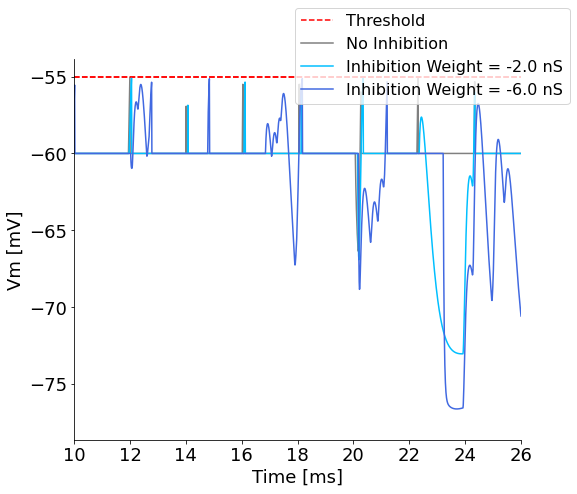

In [49]:
colors = ['c', 'deepskyblue', 'royalblue']
inhs = [0,1,3] # indexes of inibition weights to display

fig, ax = plt.subplots(1, figsize=(8,7), sharey = True)
ax.set_xlim(10,26)

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title


ax.axhline(y = r_MSO[0].get('V_th'), color = 'r', linestyle='--', label = "Threshold")
ax.plot(data_mso['times'][np.where(data_mso['senders'] == ac_r_mso[inhs[0]])], data_mso['V_m'][np.where(data_mso['senders'] == ac_r_mso[inhs[0]])], color = 'grey', label = 'No Inhibition')
ax.axhline(y = r_MSO[0].get('V_th'), color = 'r', linestyle='--')
                          
ax.plot(data_mso['times'][np.where(data_mso['senders'] == ac_r_mso[inhs[1]])], data_mso['V_m'][np.where(data_mso['senders'] == ac_r_mso[inhs[1]])], color = 'deepskyblue', label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[1]))
ax.plot(data_mso['times'][np.where(data_mso['senders'] == ac_r_mso[inhs[2]])], data_mso['V_m'][np.where(data_mso['senders'] == ac_r_mso[inhs[2]])], color = 'royalblue', label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[3]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Vm [mV]")
fig.legend()
#plt.savefig('demo.png', transparent=True)

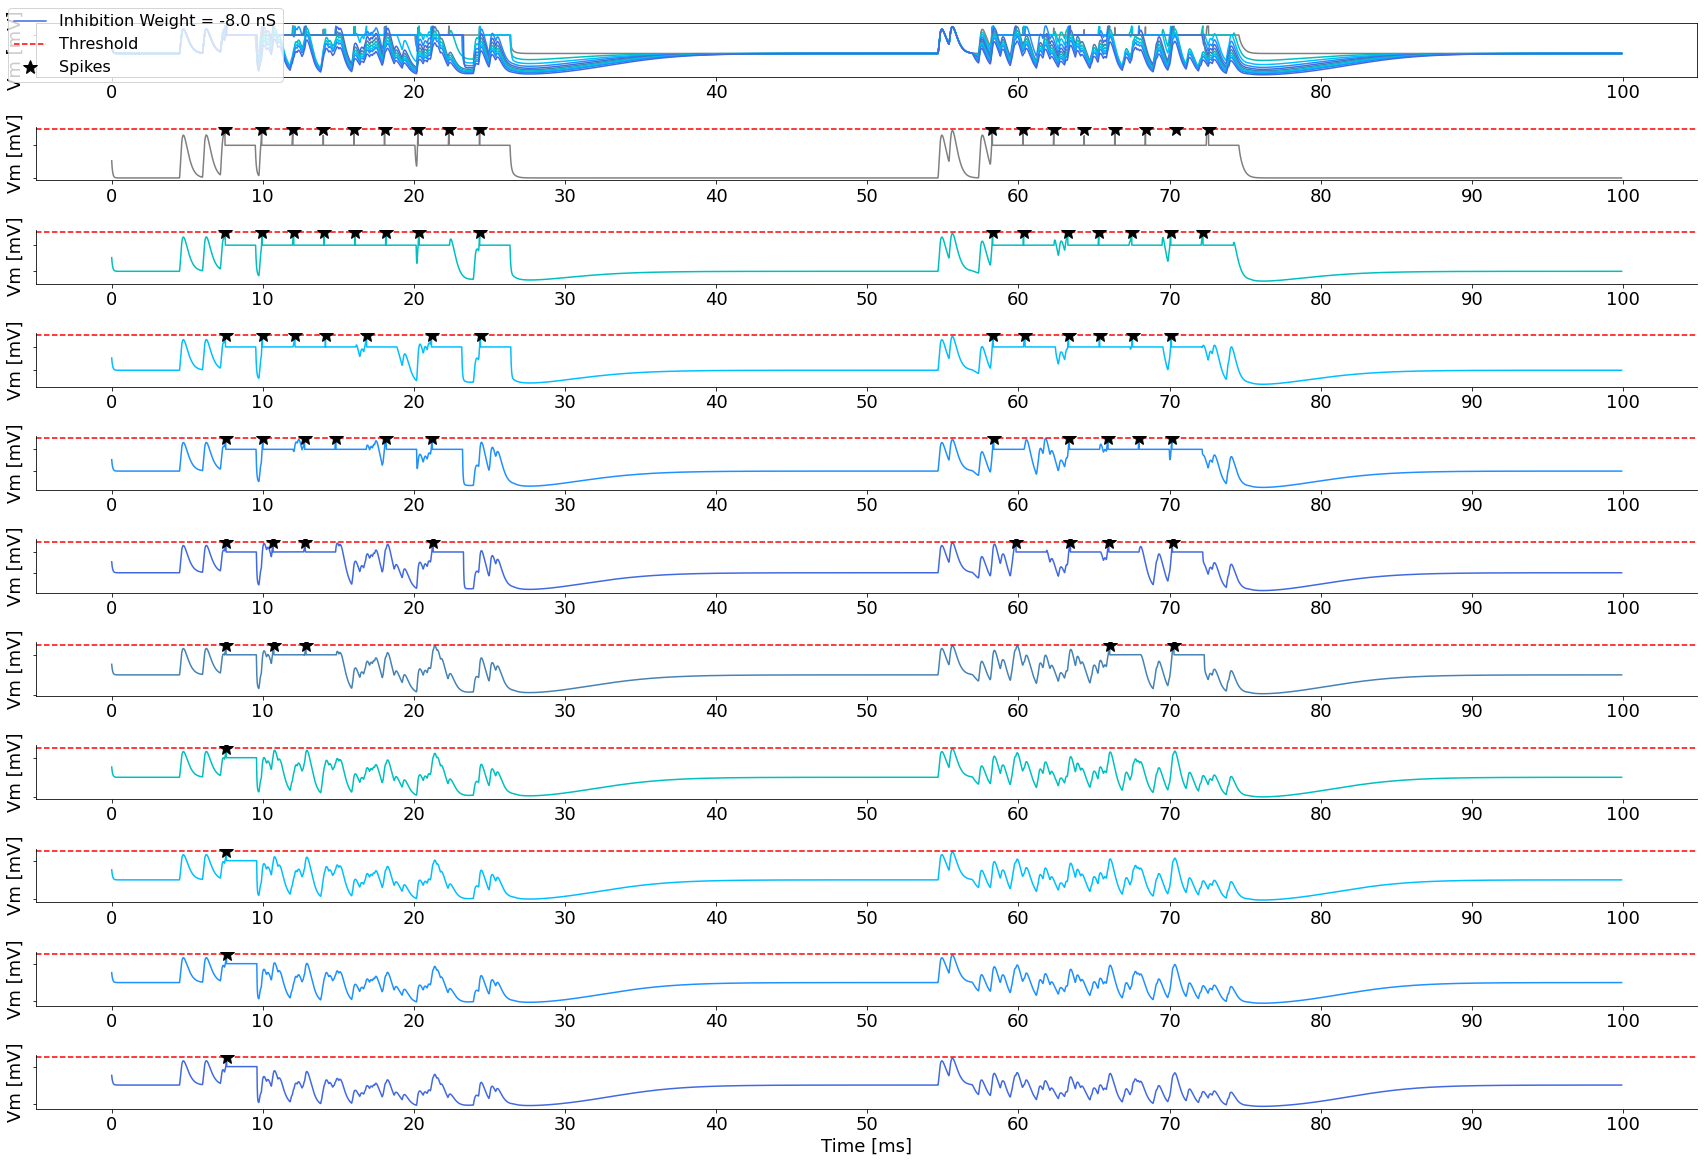

In [48]:
fig, ax = plt.subplots(11,1, figsize=(24,16))
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title
colors = ['grey','c', 'deepskyblue', 'dodgerblue', 'royalblue', 'steelblue', 'c', 'deepskyblue', 'dodgerblue', 'royalblue', 'steelblue']
fig.tight_layout()

for i in range(10):
    ax[0].plot(data_mso['times'][np.where(data_mso['senders'] == ac_r_mso[0]+i)], data_mso['V_m'][np.where(data_mso['senders'] == ac_r_mso[0]+i)], color = colors[i])
ax[0].set_ylabel("Vm [mV]")
#ax[0].set_ylabel("All", rotation = 1, fontsize=20, labelpad=20)
#ax[0].set_ylabel("Vm [mV]")
ax[0].set_yticklabels([])


for i in range(1,11):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    #ax[i].set_title("Inhibition = {}".format(MNTBCs2MSO_weights[i-1]))
    ax[i].plot(data_mso['times'][np.where(data_mso['senders'] == ac_r_mso[0]+i-1)], data_mso['V_m'][np.where(data_mso['senders'] == ac_r_mso[0]+i-1)], color = colors[i-1], label = "Inhibition Weight = {} nS".format(MNTBCs2MSO_weights[i-1]))
    ax[i].axhline(y = r_MSO[0].get('V_th'), color = 'r', linestyle='--', label = "Threshold")
    ax[i].plot(data_r['times'][np.where(data_r['senders'] == ac_r_mso[0]+i-1)],  -55*np.ones(len(data_r['times'][np.where(data_r['senders'] == ac_r_mso[0]+i-1)])), color = 'k', marker = '*', ms = 14, linestyle = 'None', label = "Spikes")
    #ax[i].set_ylabel("{} nS".format(MNTBCs2MSO_weights[i-1]), rotation = 1, fontsize=20, labelpad=20)
    ax[i].set_ylabel("Vm [mV]")
    #ax[i].set_ylabel("Vm [mV]")
    ax[i].set_xticks(np.arange(0,110,10))
    ax[i].set_yticklabels([])
ax[10].set_xlabel("Time [ms]")
#handles, labels = ax[5].get_legend_handles_labels()
fig.legend(handles, labels, loc=2)
#plt.savefig('demo2.png', transparent=True)